# Lab 11 Exercises (Machine Learning)

In this lab you'll fit Gaussian Mixture Models (GMMs) to data using the popular _scikit-learn_ package. 

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.mixture         # For GaussianMixture class

 **Run the code cell below** to generate the synthetic data for this lab.

In [2]:
def generate_GMM_data(means, covs=None, weights=None, N=1):
    """
    Samples a K-component D-dimensional Gaussian mixture.
    
    The means are KxD.
    The covariances are KxDxD. The default covariance is the DxD identity matrix.
    The weights are length K and must sum to 1. The default is uniform weights.
    
    Returns (X, c) where X is an NxD array of samples and c is a length-N vector
    of component indices, i.e. X[i] was sampled from mixture component c[i].
    """
    K, D = means.shape
    
    # Validate inputs and set default values if needed
    if covs is None:
        covs = np.tile(np.eye(D), (K,1,1))  # Stack of K D-dimensional identity matricies
    if weights is None:
        weights = np.full(K, 1/K)
    assert covs.shape == (K,D,D)
    
    # Sample a vector of component choices in proportion to weights, one for each sample
    c = np.random.choice(K, N, p=weights)  # choice() checks that weights has shape (K,1) and sums to 1
    
    # Fill an array of N samples, one component at a time
    X = np.empty((N,D))
    for k in range(K):
        X[k==c] = np.random.multivariate_normal(means[k], covs[k], np.count_nonzero(k==c))
    return X, c

# Data generation
np.random.seed(0)
U, V = np.meshgrid([-5, 0, 5], [-5, 0, 5])
means = np.column_stack([U.ravel(), V.ravel()])
X, c = generate_GMM_data(means, N=1000)

**Plot your data** by running the code cell below.

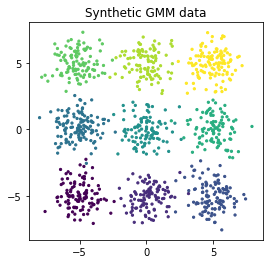

In [3]:
assert 'X' in globals(), "You must create a variable called 'X' that refers to your samples!"
assert 'c' in globals(), "You must create a variable called 'c' that refers to your component indices!"
assert X.shape == (1000,2), "X should have shape (1000, 2)!"
assert c.shape == (1000,), "c should have shape (1000,)!"
plt.scatter(*X.T, c=c, s=5)     # Plot each point (X[i,0], X[i,1]) using colour index c[i] and point size 5
plt.title("Synthetic GMM data")
plt.xticks([-5, 0, 5])
plt.yticks([-5, 0, 5])
plt.gca().set_aspect('equal')   # It's important to see this data with equal scales on each axis

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# 1. Fitting a Gaussian Mixture Model (GMM)

Exercises 1.1&ndash;1.4 ask you fit 2D data with scikit-learn's **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object.

**Run the code cell below** to define a function that will help to visualize the placement and shape of GMM components.

In [4]:
def plot_gmm(gmm):
    """
    Plots the placement of components in a Gaussian Mixture.
    
    The gmm object should be of type sklean.mixture.GaussianMixture
    """
    ax = plt.gca()
    for weight, mean, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        v, w = np.linalg.eigh(cov)
        v = 2*np.sqrt(2*v)
        u = w[0] / np.linalg.norm(w[0])
        angle = 180 * (1 + np.arctan(u[1]/u[0]) / np.pi)  # Ellipse() function needs degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle, edgecolor='k',
                                  facecolor='none', linestyle='--', linewidth=2, alpha=0.8)
        ax.add_artist(ell)

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Fit a GMM to non-overlapping, isotropic data

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the synthetic data. Use 9 mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

In [5]:
# Your code here. Aim for 1-2 lines.
gmm = sklearn.mixture.GaussianMixture(n_components=9, random_state=0, n_init=5)
gmm.fit(X)

GaussianMixture(n_components=9, n_init=5, random_state=0)

**Write plotting code** using the *plot_gmm* function provided. Once you have the ellipses plotting correctly, use the **[predict](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict)** method of the *GaussianMixture* object and use them to colour the points in the scatter plot. Your plot should look similar to:
![image](img/fig-synthetic-gmm-fit-1.png)
If you find that the GMM components do not fit perfectly to the data, try adding *n_init=5* to the arguments of your _GaussianMixture_ object. This will run the EM algorithm multiple times from different randomized initializations, and may give a higher chance of getting the 'right' clustering.

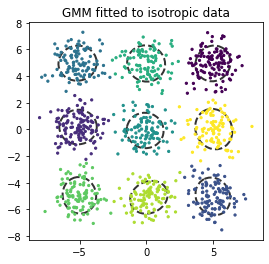

In [6]:
# Modify the code below. Aim for 2 additional lines at the beginning.
plot_gmm(gmm)
p = gmm.predict(X)
plt.scatter(*X.T, s=5, c=p)
plt.title("GMM fitted to isotropic data")
plt.gca().set_aspect('equal')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Generate overlapping, anisotropic synthetic GMM data

**Write some code** to generate 500 samples from 2-dimensional 3-component Gaussian mixture having the following parameters:

$$
\begin{align}
\pi_1 = 0.5, \quad &\boldsymbol{\mu}_1 = \begin{bmatrix} -2.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_1 = \begin{bmatrix}\phantom{-}2.0 & \phantom{-}1.0 \\ \phantom{-}1.0 & \phantom{-}2.0\end{bmatrix}\\
\pi_2 = 0.3, \quad &\boldsymbol{\mu}_2 = \begin{bmatrix} \phantom{-}2.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_2 = \begin{bmatrix}1.0 & -0.9 \\ -0.9 & 1.0\end{bmatrix}\\
\pi_3 = 0.2, \quad &\boldsymbol{\mu}_3 = \begin{bmatrix} \phantom{-}0.0 & 0.0 \end{bmatrix}, &\boldsymbol{\Sigma}_3 = \begin{bmatrix}10.0 & \phantom{-}0.0 \\ \phantom{-}0.0 & 10.0\end{bmatrix}\\
\end{align}
$$

Use the *generate_GMM_data* function from part 2. Create a variable called _X_ that refers to your samples, and create a variable called _c_ that refers to the mixture component indices (this value is directly returned by *generate_GMM_data*, so just store the result).

In [7]:
np.random.seed(0)

# Your code here. Use however many lines you need.
weights = np.array([0.5, 0.3, 0.2])

means = np.array([[-2,  0],
                  [ 2,  0],
                  [ 0,  0]])

covs = np.array([[[ 2.0,  1.0],
                  [ 1.0,  2.0]],
                 [[ 1.0, -0.9],
                  [-0.9,  1.0]],
                 [[10.0,  0.0],
                  [ 0.0, 10.0]]])

X, c = generate_GMM_data(means, covs, weights, N=500)

**Plot your data** by running the code cell below. The plot should look like this:
![image](img/fig-synthetic-gmm-data-2.png)

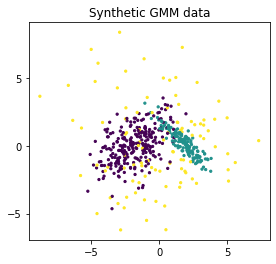

In [8]:
assert 'X' in globals(), "You must create a variable called 'X' that refers to your samples!"
assert 'c' in globals(), "You must create a variable called 'c' that refers to your component indices!"
assert X.shape == (500,2), "X should have shape (500, 2)!"
assert c.shape == (500,), "c should have shape (500,)!"
plt.scatter(*X.T, c=c, s=5)     # Plot each point (X[i,0], X[i,1]) using colour index c[i] and point size 5
plt.title("Synthetic GMM data")
plt.xticks([-5, 0, 5])
plt.yticks([-5, 0, 5])
plt.gca().set_aspect('equal')   # It's important to see this data with equal scales on each axis

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.3 &mdash; Fit a GMM to the anisotropic, overlapping data

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the synthetic data you generated in Exercise 1.2. Use 3 mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

In [9]:
# Your code here. Aim for 1-2 lines.
gmm = sklearn.mixture.GaussianMixture(n_components=3, random_state=0, n_init=5)
gmm.fit(X)

GaussianMixture(n_components=3, n_init=5, random_state=0)

**Write plotting code** (like Exercise 3.1) using the **[predict](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict)** method. Your plot should look like this (colours may differ):
![image](img/fig-synthetic-gmm-fit-2.png)

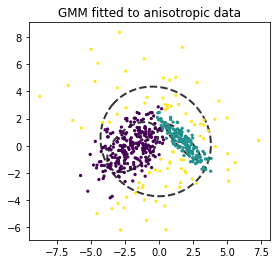

In [10]:
# Modify the code below. Aim for 2 additional lines at the beginning
plot_gmm(gmm)
p = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], s=5, c=p)
plt.title('GMM fitted to anisotropic data')
plt.gca().set_aspect('equal')

**Write plotting code** to visualize the probability $p(z_{ik} \mid \mathbf{x}_i)$ that component $k$ generated data point $\mathbf{x}_i$. Use the **[predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.predict_proba)** method of the _GaussianMixture_ object to get the probabilities. Because there are $K=3$ components, you can visualize these probabilities by using $\begin{bmatrix} p(z_{i1} \mid \mathbf{x}_i) & p(z_{i2} \mid \mathbf{x}_i) & p(z_{i3} \mid \mathbf{x}_i) \end{bmatrix}$ as the values colour $\begin{bmatrix} r_i & g_i & b_i \end{bmatrix}$ for data point $i$. Your plot should look like this:
![image](img/fig-synthetic-gmm-fit-2-probs.png)

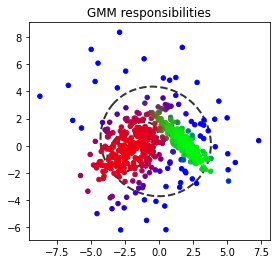

In [11]:
# Modify the code below. Aim for 2 additional lines at the beginning
plot_gmm(gmm)
p = gmm.predict_proba(X)

plt.scatter(*X.T, s=20, c=p)
plt.title('GMM responsibilities')
plt.gca().set_aspect('equal')

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.4 &mdash; Sample from spatially clustered pixels using a GMM

**Write fitting code** to fit a **[sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)** object to the _RGBXY_ data (the ladybug) that you generated in the previous lab. Use **15** mixture components in your answer. You should use the argument *random_state=0* to ensure reproducibility. Create a variable called _gmm_ that refers to your new *GaussianMixture* object.

**Run the code below** the generate the RGBXY from the ladybug image: 

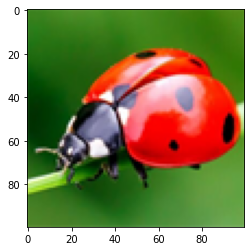

In [12]:
image = plt.imread('ladybug.png')
plt.imshow(image);
RGB = image.reshape(-1, 3)
h, w, _ = image.shape                                 # Get the width and height of the image
X, Y = np.meshgrid(np.arange(w, dtype=np.float32),
                   np.arange(h, dtype=np.float32))    # Enumerate the (x,y) indices of all pixels
RGBXY = np.column_stack([RGB, X.ravel(), Y.ravel()])  # Stack [r g b], [x], [y] to get [r g b x y]

**Write a code below** to fit a GMM model into RGBXY data.

In [13]:
# Your code here. Aim for 1-2 lines.
gmm = sklearn.mixture.GaussianMixture(n_components=15, random_state=0)
gmm.fit(RGBXY);

**Generate 5000 samples** from your fitted mixture model by using the **[sample](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.sample)** method of the _GaussianMixture_ object. The resulting sample matrix should have shape (5000,5) where each row is a vector $\begin{bmatrix}r & g & b & x & y\end{bmatrix}$. Create a variable _X_ to refer to your new samples. Note that the _sample_ function also returns a component membership vector, but you can ignore it.

In [14]:
# Your code here. Aim for 1 line.
X, _ = gmm.sample(5000)


**Plot the samples** as if they were pixels at location $(x,y)$ with colour $(r,g,b)$. Use a single call to Matplotlib's _scatter_ function. Your ladybug should look something like this:
![image](img/fig-synthetic-ladybug.png)

*Hint:* The _scatter_ function will fail if you use any colour values outside range $[0.0,1.0]$, yet there's no guarantee that a Gaussian will produce values within this range. Use the **[np.clip](https://numpy.org/devdocs/reference/generated/numpy.clip.html)** function to clamp the $(r,g,b)$ values to this range.

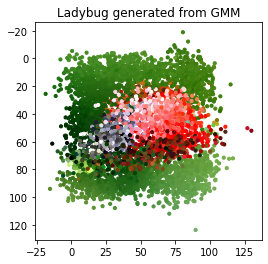

In [15]:
# Your code here. Aim for 2-5 lines.
RGB, XY = np.split(X, [3], axis=1)
plt.scatter(*XY.T, c=np.clip(RGB, 0, 1), s=10);
plt.title("Ladybug generated from GMM")

# Keep these lines at the end.
plt.gca().invert_yaxis()         # This line makes sure the ladybug appears upright!
plt.gca().set_aspect('equal')    # This line makes sure the ladybug isn't squished!

This final exercise was designed to show:
* how to train a GMM on 5-dimensional data (RGBXY);
* how to visualize 5 dimensional samples in a 2D plot, by using a combination of colour and space;
* that sampling from a generative model, such as a GMM, is a good way to see whether the samples it generates are "realistic" or whether they're missing important aspects of the real data; and
* that a Gaussian or a GMM, when used as a generative model, can produce samples that have values outside the range of the original training data (for example, negative XY coordinates).